In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from utils._raised_cosine_basis import makeRaisedCosBasis
import torch.nn.functional as F



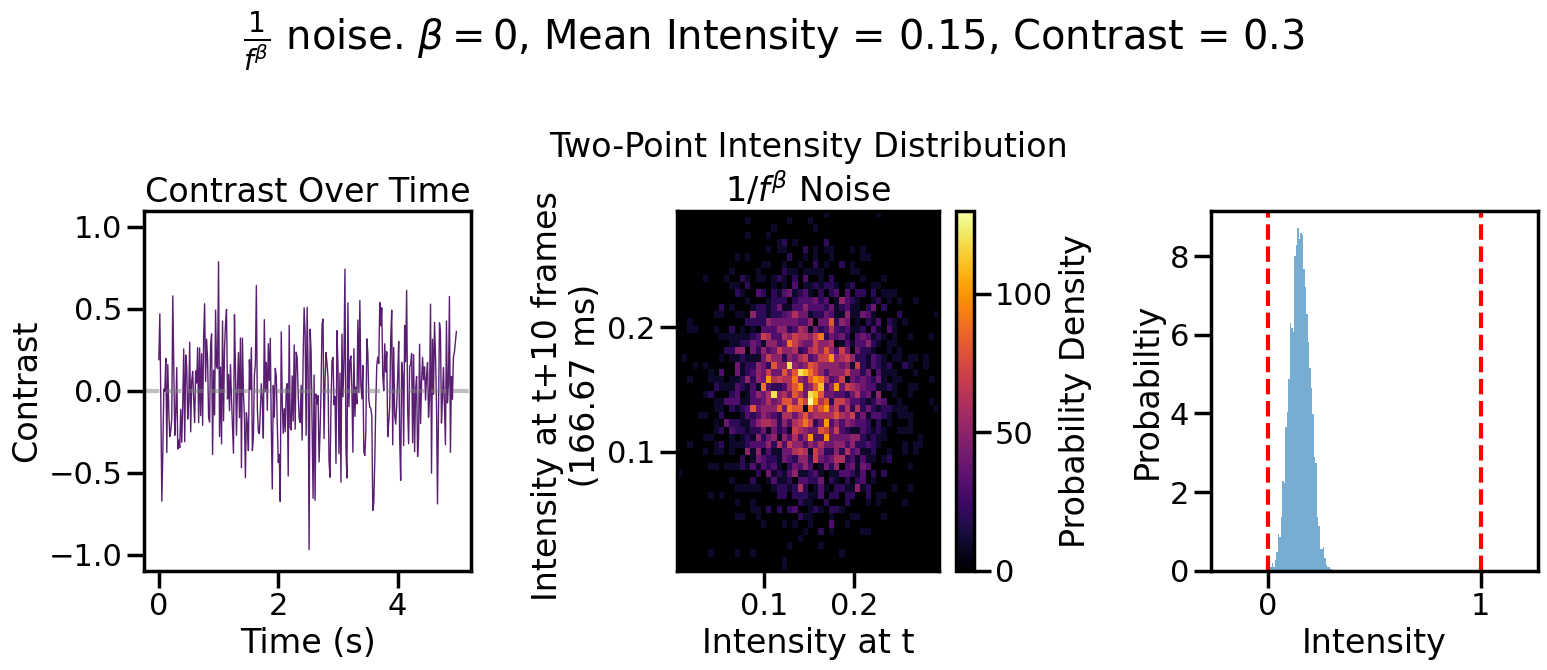

In [20]:
from utils.stim_utils import generate_1_f_noise, plot_stim
beta= 0
mean_intensity = 0.15
desired_contrast = 0.3
stim_duration = 5
trials = 10
frame_rate = 60
dt_stim = 1/frame_rate
frame_dwell = 1
tau = 10

all_noise = []
all_contrast = []
for trial in range(trials):
    noise, contrast = generate_1_f_noise(
        beta, frame_rate * stim_duration, frame_rate,
        frame_dwell, mean_intensity, desired_contrast,
        noise_seed=trial)
    all_noise.append(noise)
    all_contrast.append(contrast)

noise_t = np.concatenate(all_noise)
contrast_t = np.concatenate(all_contrast)
stim = np.array(all_contrast)

plot_stim(noise_t=noise_t, contrast_mat=stim,
          beta=beta,
          mean_intensity=mean_intensity,
          desired_contrast=desired_contrast,
          tau=10, frame_rate=60, figsize=(16,7))

In [21]:
stim_v = stim.reshape(-1)
stim_v.shape

(3000,)

## Main API 

In [ ]:
import torch
import torch.nn.functional as F

def make_X_cond_conv(stim: torch.Tensor, basis: torch.Tensor) -> torch.Tensor:
    """
    stim:  [T]
    basis: [L, P] causal basis; basis[0] corresponds to lag 1 (previous bin) if that's your convention.
    returns X_cond: [T, P]
    """
    stim = stim.reshape(1, 1, -1)        # [N=1, C=1, T]
    L, P = basis.shape

    # Build conv kernels: for each basis p, kernel[k] multiplies stim[t-k]
    # Our S_lag version uses [stim[t-1],...,stim[t-L]]. So kernel should align with that.
    # F.conv1d uses cross-correlation; easiest is to flip so it matches lagging.
    weight = basis.T.flip(1).reshape(P, 1, L)  # [P,1,L]

    # Left pad with L zeros so output has length T and uses only past
    y = F.conv1d(F.pad(stim, (L, 0)), weight)  # [1,P,T]
    return y.squeeze(0).T                      # [T,P]

In [ ]:
# create CBEM object
myCBEM = CBEM_basic(0.1); # bin size is 0.1 ms

# set stimulus & spike times
window = range(12000,70000); # range of bins to use 
myCBEM.setObservations(stimulus, spkTimes_bins, window)

# initialize parameters
myCBEM.randomizeParameters()
B_init = myCBEM.vectorizeParameters()

In [ ]:
import torch
import torch.nn.functional as F

def make_X_cond_conv(stim: torch.Tensor, basis: torch.Tensor) -> torch.Tensor:
    """
    stim:  [T]
    basis: [L, P] causal basis; basis[0] corresponds to lag 1 (previous bin) if that's your convention.
    returns X_cond: [T, P]
    """
    stim = stim.reshape(1, 1, -1)        # [N=1, C=1, T]
    L, P = basis.shape

    # Build conv kernels: for each basis p, kernel[k] multiplies stim[t-k]
    # Our S_lag version uses [stim[t-1],...,stim[t-L]]. So kernel should align with that.
    # F.conv1d uses cross-correlation; easiest is to flip so it matches lagging.
    weight = basis.T.flip(1).reshape(P, 1, L)  # [P,1,L]

    # Left pad with L zeros so output has length T and uses only past
    y = F.conv1d(F.pad(stim, (L, 0)), weight)  # [1,P,T]
    return y.squeeze(0).T                      # [T,P]

## Misc

In [26]:
import torch
import torch.nn.functional as F

def log_one_plus_exp_x_torch(x: torch.Tensor, maxG: float) -> torch.Tensor:
    """
    Exact match to MATLAB logOnePlusExpX forward pass.

    x:    any shape
    maxG: scalar threshold where we linearize softplus (f=x)
    """
    # MATLAB flattens: X = X(:). We'll keep shape, but logic is elementwise.
    x = x.to(dtype=torch.float32)

    lessT = x <= -30.0
    greaterT = x >= maxG
    toFit = (~lessT) & (~greaterT)

    f = x.clone()  # default f = x (this automatically matches the "greaterT" region too)
    f = torch.where(lessT, torch.full_like(f, 1e-15), f)

    # middle region: f = log(1+exp(x)) = softplus(x)
    f_mid = F.softplus(x)
    f = torch.where(toFit, f_mid, f)

    return f

In [23]:
nLinearRFs = 10 #;     %number of stimulus basis functions
numShortSHFilts = 5#; %each is 0.4ms long - used for refractory period
nSHfilters = 7+numShortSHFilts#;%7+

nInh = 1#;
nExc = 1#

dt = 1e-4

RFstart = 2e-3 #;%0?
RFend   = 150e-3#;%150e-3 or 180e-3;
b = 0.02
t, B_orth, B_raw = makeRaisedCosBasis(nLinearRFs, dt, [RFstart, RFend], b, zflag=0)
# CBEM.stimNumBasisVectors = size(CBEM.stimBasisVectors,2);
stimNumBasisVectors = B_orth.shape[1]


In [24]:
ntotalConds = nInh + nExc
InhConds = nExc + np.arange(nInh)
ExcConds = np.arange(nExc) 

E_s = np.zeros(ntotalConds)      # reversal potentials per conductance
g_s_bar = np.zeros(ntotalConds)  # gain/scale per conductance
condType = np.zeros(ntotalConds) # type flags (stim-driven vs leak vs etc.) #0= exc, 1 = inh, 2= ahp, 3=true exc, 4=true inh
f_s = [None] * ntotalConds
k_s = [None] * ntotalConds
k_s_section = [None] * ntotalConds

E_l = -80
E_s[ExcConds] = 0
E_s[InhConds] = -80

condType[ExcConds] = 2
condType[InhConds] = 2

g_l = 10000/4 #4ms time constant
tau_s = 4e-3

g_l = 1.0 / tau_s   # = 250
log_g_l = np.log(g_l)

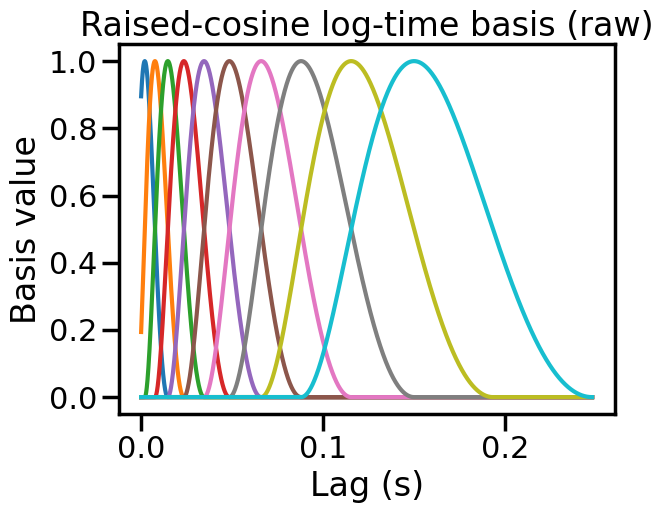

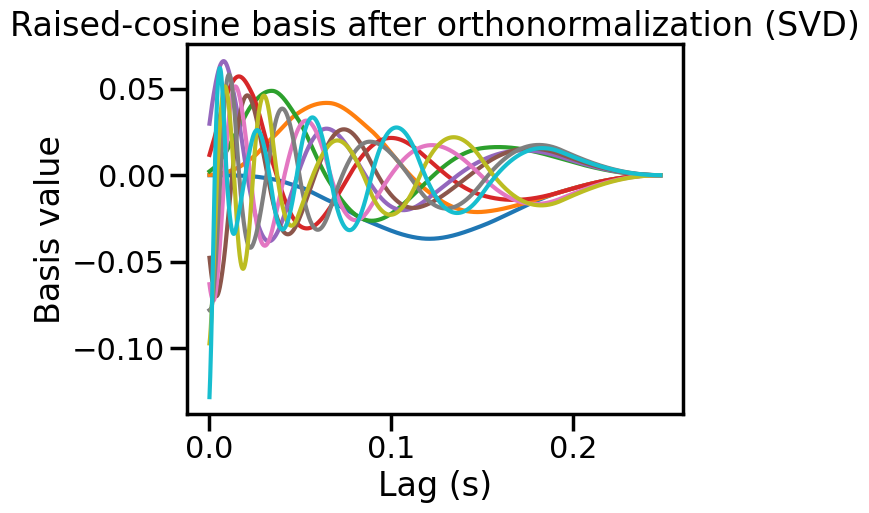

In [25]:

plt.figure()
plt.plot(t, B_raw)
plt.xlabel("Lag (s)")
plt.ylabel("Basis value")
plt.title("Raised-cosine log-time basis (raw)")
plt.show()

plt.figure()
plt.plot(t, B_orth)
plt.xlabel("Lag (s)")
plt.ylabel("Basis value")
plt.title("Raised-cosine basis after orthonormalization (SVD)")
plt.show()


In [ ]:
def getSimpleStimulusBasis(dt : float, nLinearRFs, RFstart, RFend, b):
    t, B_orth, B_raw = makeRaisedCosBasis(nLinearRFs, dt, [RFstart, RFend], b, zflag=0)
    return B_orth


## JAX BASE CLASS

In [ ]:
"""
Simple class to solve the Conductance-based encoding model for retinal ganglion cells in:
    K. W. Latimer,  F. Rieke, & J. W. Pillow (2019). Inferring synaptic inputs from spikes with a conductance-based neural encoding model.eLife 8 (2019): e47012.

Requires Jax for computations.

Copyright (c) 2022 Kenneth Latimer
"""

# import numpy as np
# import scipy
# import jax.numpy as jnp
# import jax
# from jax import random
# import math



def getSimpleStimulusBasis(dt : float) -> tuple[np.ndarray, np.ndarray]:
    t, B_orth, B_raw = makeRaisedCosBasis(nLinearRFs, dt, [RFstart, RFend], b, zflag=0)
    return B_orth

class CBEM_basic:
    """
    A basic implementation of the Conductance-based encoding model.
    The model has three inputs: excitatory and inhibitory conductance (soft-rectified, affine function in the stimulus)
                                a linear spike history (not conductance-based)
    The 'setObservations' sets up the data: current stimulus and spike train.
    """
    def __init__(self,  binSize_ms : float, basis_conductance : np.ndarray = None, basis_hspk : np.ndarray = None):
        """
        Initialize simple CBEM with one excitatory and one inhibitory conductance which share input.
        
        Note: bases are orthogonalized before fitting. Filter parameters will be in terms of the orthogonalized basis.

        Args:
          binSize_ms:           time bin size in milliseconds
          basis_conductance:    [BT_stim x P_stim], if None then getSimpleStimulusBasis(binSize_ms) -
                                Each column is a basis function for the conductances (conductances share a basis).
                                The basis is assumed to be causal: basis_conductance[0,:] are the basis weights for the previous time bin.
          basis_hspk:           [BT_hspk x P_hspk], if None then getSimpleSpkHistBasis(binSize_ms) -
                                Each column is a basis function for the spike history.
                                The basis is assumed to be causal: basis_conductance[0,:] are the basis weights for the previous time bin.
        """

        # discretization size
        self.binSize_ms    = binSize_ms
        assert self.binSize_ms > 0, "bin size must be positive"

        # setup bases for filters
        if(basis_conductance is None):
            basis_conductance,tts = getSimpleStimulusBasis(binSize_ms);
            
        if(basis_hspk is None):
            basis_hspk,tts = getSimpleSpkHistBasis(binSize_ms);

        assert basis_conductance.ndim <= 2, "Basis cannot be more than 2 dimensions"
        assert basis_hspk.ndim <= 2, "Basis cannot be more than 2 dimensions"

        self.basis_conductance_0 = basis_conductance.reshape((basis_conductance.shape[0],-1));
        self.basis_hspk_0      = basis_hspk.reshape((basis_hspk.shape[0],-1));
        self.basis_conductance   = jnp.array(scipy.linalg.orth(self.basis_conductance_0));
        self.basis_hspk        = jnp.array(scipy.linalg.orth(self.basis_hspk_0 ));

        # setup LIF parameters 
        self.E_input = jnp.array([0, -80]); # mV
        self.E_l = -60; # mV
        self.g_l = 200; 
        self.V_0 = self.E_l; # initial voltage
        self.frNonlinearity = {"alpha" : 90, "mu" : -53, "beta" : 1.67}; # "beta" : 1.67 or could be 1/0.45?

        # no stimulus set yet - won't run model
        self.X_cond = None;
        self.X_lin  = None;
        self.spkTimes_bins  = None;

        self._B_cond = None;
        self._B_hspk  = None;
        self.N_pixels = 0;

    # Properties for the model parameters
    @property
    def B_cond(self):
        """jnp.ndarray: [(BT_stim + 1) x 2] - The conductance filters and baseline parameters."""
        return self._B_cond;

    @B_cond.setter
    def B_cond(self, value : jnp.ndarray):
        """Note: cannot change filter size"""
        assert not (self._B_cond is None), "model filters not initialized"
        assert value.shape == self._B_cond.shape, "Conductance filter is incorrect shape"
        self._B_cond = value;

    @property
    def B_hspk(self):
        """jnp.ndarray: [BT_hspk x 1] - The spike history filter parameters."""
        return self._B_hspk;

    @B_hspk.setter
    def B_hspk(self, value : jnp.ndarray):
        """Note: cannot change filter size"""
        assert not (self._B_hspk is None), "model filters not initialized"
        assert value.shape == self._B_hspk.shape, "Spike history filter is incorrect shape"
        self._B_hspk = value;


    def setObservations(self, Stimulus : np.ndarray, spkTimes_bins : list[int], window : range) -> None:
        """
        Initializes the stimulus and spike train observation for this neuron.
        This assumes only one spike per bin is possible.

        Args:
          Stimulus:         [T_stim x number of pixels] - Pixels are treated independently
          spkTimes_bins:    List of the spike times in bins.
          window:           The window of stimulus and spikes to fit. This input allows you to cut out the first 
                            part of the given spike train to avoid edge effects for spike history or stimulus.
        """
        window = jnp.array(window);
        # get the conductance desgin matrix(same for both conductances)
        self.X_cond   = jnp.array(utils.convolveStimulusWithBasis(Stimulus, self.basis_conductance)[window,:]);
        self.N_pixels = math.prod(Stimulus.shape[1:]);

        # get spike history
        X_l, Y_0      = utils.convolveSpksWithBasis(spkTimes_bins, self.basis_hspk, Stimulus.shape[0]);
        self.X_lin    = jnp.array(X_l[window,:]);

        # get spike times within the current window
        self.Y              = jnp.array(Y_0[window]); # vectorized spike times
        # self.spkTimes_bins  = jnp.where(jnp.in1d(window, spkTimes_bins))[0]
        self.spkTimes_bins  = jnp.where(jnp.isin(window, spkTimes_bins))[0]  
        
        # setup empty parameters
        self._B_cond = jnp.zeros((self.basis_conductance.shape[1] * self.N_pixels + 1, 2));
        self._B_hspk  = jnp.zeros((self.basis_hspk.shape[1]));

    ### functions for handling the voltage model
    def getConductances(self, B_cond : jnp.ndarray = None) -> jnp.ndarray:
        """
        Computes the conductances given the conductance filter parameters for the current stimulus.
        The conductance nonlinearity is a soft-rectifier.

        Args:
          B_cond:   [(P_stim + 1) x 2], if None then self.get_B_cond() -
                        Parameters of the two conductance filters as weights on the basis functions. First column is excitatory, second inhibitory.
                        The last entry is the basline term.
        
        Returns:
          gs  [T_stim x 2] - first column is excitatory conductance, second inhibitory
        """
        if B_cond is None:
            B_cond = self._B_cond
        assert not (self.X_cond is None), "Stimulus not initialized!"
        assert jnp.shape(B_cond) == jnp.shape(self._B_cond), "Conductance parameters not correct shape"

        return jax.nn.softplus(self.X_cond @ B_cond);

    def getVoltage(self, B_cond : jnp.ndarray = None) -> jnp.ndarray:
        """
        Computes the voltage given the conductance parameters for the set stimulus.
        
        Args:
          B_cond:  [(P_stim + 1) x 2], if None then  self.get_B_cond() -
                        Parameters of the two conductance filters as weights on the basis function. First column is excitatory, second inhibitory.
                        The last entry is the basline term.
                        
        Returns:
          V [T_stim] - the solved voltage in millivolts
        """
        if B_cond is None:
            B_cond = self._B_cond

        gs = self.getConductances(B_cond);
        return jax.jit(utils.getVoltage)(gs, self.E_input, self.g_l, self.E_l, self.V_0, self.binSize_ms);

    def firingRateNonlinearity(self, V_tot : jnp.ndarray) -> jnp.ndarray:
        """
        Computes the firing rate nonlinearity on the given total voltage.
        The nonlinearity is alpha * softplus((V_tot - mu)/beta)

        - self.frNonlinearity holds the parameters alpha, beta, and mu

        Args:
          V_tot:    [T] - The total voltage terms.
                    Total voltage is the membrane potential from the membrane potential equation plus spike history terms.

        Returns:              
          spikeRate [T] - the firing rate for each term in V_tot
        """
        return self.frNonlinearity["alpha"] * jax.nn.softplus((V_tot - self.frNonlinearity["mu"])/ self.frNonlinearity["beta"]);

    def getSpikeHistory(self, B_hspk : jnp.ndarray = None) -> jnp.ndarray:
        """
        Computes the spike history given the parameters for the set spike train. (A simple linear function)

        Args:
          B_hspk:   [P_hspk x 1], if None then self.get_B_hspk() - Parameters of the spike history filter as weights on the basis functions.
                        
        Returns:
          hspk  [T_stim] - the linear spike history
        """
        if B_hspk is None:
            B_hspk = self._B_hspk
        assert jnp.shape(B_hspk) == jnp.shape(self._B_hspk), "Linear parameters not correct shape"

        return self.X_lin @ B_hspk;

    def getSpikeRate(self, B_cond  : jnp.ndarray = None, B_hspk  : jnp.ndarray = None) -> jnp.ndarray:
        """
        Computes the spike rate at each time given the conductance and spike history parameters for the set stimulus & spike history.

        Args:
          B_cond:   [(P_stim + 1) x 2], if None then  self.get_B_cond() - Parameters of the two conductance filters as weights on the basis function. First column is excitatory, second inhibitory.
          B_hspk:   [P_hspk x 1], if None then  self.get_B_hspk() - Parameters of the spike history filter as weights on the basis functions.

        Returns            
          spikeRate [T_stim] - the firing rate in each bin in units of spikes/sec
        """
        if B_cond is None:
            B_cond = self._B_cond
        if B_hspk is None:
            B_hspk = self._B_hspk

        V_tot  =  self.getVoltage(B_cond) + self.getSpikeHistory(B_hspk); # add membrane voltage and spike history 
        return self.firingRateNonlinearity(V_tot); # pass through transfer function

    ### log likelihood of spikes
    def getLogLike(self, B_cond : jnp.ndarray = None, B_hspk : jnp.ndarray  = None) -> jnp.ndarray:
        """
        Computes the log likelihood at each time bin given the conductance and spike history parameters for the set stimulus & spike history.
        This function uses a truncated Poisson likelihood. That is, Poisson(0 | rate) for bins without a spike and
                                                                 (1-Poisson(0 | rate)) for bins with a spike.

        Args:
          B_cond:   [(P_stim + 1) x 2], if None then self.get_B_cond() - Parameters of the two conductance filters as weights on the basis function. First column is excitatory, second inhibitory.
          B_hspk:   [P_hspk x 1], if None then  self.get_B_hspk() - Parameters of the spike history filter as weights on the basis functions.
                        
        Returns:
          ll_bins [T_stim] - the log likelihood of the observation (a spike or no spike) at each bin.
        """
        if B_cond is None:
            B_cond = self._B_cond
        if B_hspk is None:
            B_hspk = self._B_hspk

        ll_bins = -(self.binSize_ms/1e3) * self.getSpikeRate(B_cond, B_hspk);
        ll_bins = ll_bins.at[self.spkTimes_bins].set(jnp.log(1 - jnp.exp(ll_bins[self.spkTimes_bins])));
        return ll_bins;

    ### functions for handling parameters
    def randomizeParameters(self, offset_term_mean : float = 10, std_cond : float = 1, std_lin : float = 1) -> None:
        """
        Sets the parameters of the model using i.i.d. normal draws.
        All filter weights are drawn with mean 0.

        Args:
          offset_term_mean: Mean of the baseline term of the conductances. This probably should be positive.
          std_cond:         Standard deviation of the conductance parameters.
          std_lin:          Standard deviation of the spike history parameters.
                        
        Returns:
          A tuple (B_cond, B_hspk)

            B_cond: [(P_stim + 1) x 2] - Parameters of the two conductance filters as weights on the basis function. First column is excitatory, second inhibitory.

            B_hspk:  [P_hspk x 1] - Parameters of the spike history filter as weights on the basis functions.
        """
        assert not (self._B_cond is None), "model filters not initialized"
        self._B_hspk  = jnp.array(np.random.normal(size=self._B_hspk.shape)*std_cond);
        self._B_cond = jnp.array(np.random.normal(size=self._B_cond.shape)*std_lin);
        self._B_cond = self._B_cond.at[-1,:].set(self._B_cond[-1,:] + offset_term_mean);
        return (self._B_cond, self._B_hspk);


    def vectorizeParameters(self, B_cond : jnp.ndarray = None, B_hspk : jnp.ndarray  = None) -> jnp.ndarray:
        """
        Flatens the parameters into a vector for optimization.

        Args:
          B_cond:   [(P_stim + 1) x 2], if None then self.B_cond -
                    Parameters of the two conductance filters as weights on the basis function. First column is excitatory, second inhibitory.
          B_hspk:   [P_hspk x 1], if None then self.B_hspk -
                    Parameters of the spike history filter as weights on the basis functions.
                    The last entry is the basline term.
                        
        Returns:
          B [(P_stim + 1) * 2 + P_hspk] - Flattened B_cond and B_hspk
        """
        assert not (self._B_cond is None), "model filters not initialized"
        if B_cond is None:
            B_cond = self._B_cond
        if B_hspk is None:
            B_hspk = self._B_hspk
        return np.concatenate((B_cond.flatten(), B_hspk.flatten()));

    def devectorizeParameters(self, B : jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray]:
        """
        Takens in a vector of the parameters and returns them in more convenient separate, matrix forms.

        Args:
          B:  [(P_stim + 1) * 2 + P_hspk] - Flattened B_cond and B_hspk.
                This should correspond to concatenate((B_cond.flatten(), B_hspk.flatten))
        
        Returns:
          A tuple (B_cond, B_hspk)

            B_cond: [(P_stim + 1) x 2] - 
                Parameters of the two conductance filters as weights on the basis function. First column is excitatory, second inhibitory.

            B_hspk:  [P_hspk x 1] - 
                Parameters of the spike history filter as weights on the basis functions.
                The last entry is the basline term.
        """
        assert not (self._B_cond is None), "model filters not initialized"
        assert jnp.ndim(B) == 1 and B.size == self._B_cond.size + self._B_hspk.size, "B is incorrect size: must be a vector containing both conductance and linear terms"
        return (B[0:self._B_cond.size].reshape(self._B_cond.shape),  B[self._B_cond.size:].reshape(self._B_hspk.shape));

    def setParametersFromVector(self, B : jnp.ndarray) -> None:
        """
        Sets the current parameters from a vectorized form.

        Args:
          B:    [(P_stim + 1) * 2 + P_hspk] - Flattened B_cond and B_hspk.
                This should correspond to concatenate((B_cond.flatten(), B_hspk.flatten))
        """
        self._B_cond, self._B_hspk = self.devectorizeParameters(B)



    # Vectorized negative log likelihood functions for optimization
    def vectorizedNegLogLike(self, B : jnp.ndarray) -> jnp.ndarray:
        """
        Computes the negative log likelihood for the set stimulus and spike train.
        Takes in the parameters in a vectorized form for use with optimizers.

        Args:
          B:    [(P_stim + 1) * 2 + P_hspk] - Flattened B_cond and B_hspk.
                This should correspond to concatenate((B_cond.flatten(), B_hspk.flatten))

        Returns:
          nll [1] - The total negative log likelihood for the setup stimulus.
        """
        (B_cond, B_hspk) = self.devectorizeParameters(B);
        return -(self.getLogLike(B_cond, B_hspk).sum());
        
    def vectorizedPenalizedNegLogLike(self, B : jnp.ndarray, conductance_penalty : list[float] = [1, 0.2]) -> jnp.ndarray:
        """
        Computes the penalized negative log likelihood for the set stimulus and spike train.
        Takes in the parameters in a vectorized form for use with optimizers.
        The penalty terms are the weighted squared norms of the conductance filters.
        
        Args:
          B: [(P_stim + 1) * 2 + P_hspk] - Flattened B_cond and B_hspk.
                    This should correspond to concatenate((B_cond.flatten(), B_hspk.flatten))
          conductance_penalty:  [2] -
                    The weights of the penalty on the squared norms of the filter weights.
                    The first term is for the excitatory and the second for the inhibitory.
                    The baseline conductance terms do not contribute to this penalty.

        Returns:
          nll [1] - The total negative log likelihood for the setup stimulus plus the penalties.
        """
        assert not (self._B_cond is None), "model filters not initialized"
        (B_cond, B_hspk) = self.devectorizeParameters(B);
        nll = -(self.getLogLike(B_cond, B_hspk).sum());
        for ii in range(self._B_cond.shape[1]):
            nll += conductance_penalty[ii] * jnp.sum(B_cond[0:-1, ii] ** 2);
        return nll;

    def getConductanceFilter(self, cc : int) -> jnp.ndarray:
        """
        Gets the full conductance filter (basis times weights) for one of the conductance filters.

        Args:
          cc: Index of the conductance filter to return. 0 is excitatory, 1 is inhibitory.

        Returns:
          k_stim [BT_stim x N_pixels] - The filter for each pixel.
        """

        assert not (self._B_cond is None), "model filters not initialized"
        return self.basis_conductance @ jnp.reshape(self._B_cond[0:(self.N_pixels * self.basis_conductance.shape[1]),cc], (self.basis_conductance.shape[1], self.N_pixels));

    def getSpikeHistoryFilter(self) -> jnp.ndarray:
        """
        Gets the full spike history filter (basis times weights).

        Returns:
          h_spk [BT_hspk x 1] - The full spike history filter.
        """
        assert not (self._B_cond is None), "model filters not initialized"
        return self.basis_hspk @ self._B_hspk;

    # simulate a set of spike trains given the currently set stimulus
    def simulateSpikeTrains(self, Y_init : np.ndarray, N : int = None) -> jnp.ndarray:
        """
        Simulates a set of spike trains with the currently set stimulus. This can be really slow!
        This function requires an initial set of spikes to avoid dealing with edge effects of the spike history filter.

        Args:
          Y_init:  [T_0 x (N or 1)] - A matrix of ones and zerosThe initial spike trains. T_0 should be less than T_stim
          N:       (positive integer) - The number of simulations: only use this if Y_init.shape[1] == 1 and you want more than one simulation.
                                             If N > 1 and Y_init.shape[1] == 1, it uses the same initial spike train for all simulations.
                                                                 
        Returns:
          sps [T_stim x N] - A matrix of spikes for each of the N simulations. Spikes are either 1 or 0.
        """
        assert not (self._B_cond is None), "model filters not initialized"
        Y_init = Y_init.reshape((Y_init.shape[0], -1));
        if N is None:
            N = Y_init.shape[1];
        assert (N == Y_init.shape[1] or Y_init.shape[1] == 1), "Invalid arguments for number of simulations"

        T = self.X_cond.shape[0]; # total simulation length
        T_0 = Y_init.shape[0]; # initial seed length
        P_lin = self.basis_hspk.shape[0];
        assert T_0 > P_lin and T_0 > self.basis_conductance.shape[0], "initial spike train too short for bases"
        assert N > 0, "no simulations requested"

        # sets up spikes
        sps = jnp.zeros((T, N));
        sps = sps.at[:T_0, :].set(Y_init);

        # gets voltage (in this model, it's determined by the stimulus. Would need a more complex function for spike-dependent conductances)
        V = self.getVoltage();
        h_spk = jnp.flip(self.getSpikeHistoryFilter()).reshape((1, -1));

        # random values for spike generation
        key = random.PRNGKey(0);
        rs = random.uniform(key, (T, N));

        print("Running " + str(N) + " simulations... (WARNING: This function can be painfully slow!)");
        print("T_0 = " + str(T_0));
        for tt in range(T_0, T):
            if tt % 500 == 0:
                print("tt = " + str(tt) + " / " + str(T));
            # gets spike history & adds to voltage
            V_c = h_spk @ sps[(tt-P_lin):tt,:];
            V_c += V[tt];

            # gets spike probability
            fr = (self.binSize_ms/1e3) * self.firingRateNonlinearity(V_c);
            p_1 = 1 - (jnp.exp(-fr));
            spiked = (rs[tt,:] < p_1).flatten();

            # generates spike
            sps = sps.at[tt, :].set(spiked);
        print("Done.");
        return sps;

